In [1]:
# tax 78 % på NPV på petroleum
# tax 22 % yearly på profit for WC (med fremførbart underskudd)

##### TODO
 - Legg inn eksisterende bilder i Overleaf
 - Legge til tax
 - Lag siste bilder
 - LCOE 2031 sensitivity
 - Forringelse https://www.nve.no/media/17785/metode-og-forutsetninger-for-beregning-av-kostnader-for-kraftproduksjon.pdf#page=1

## Imports

In [2]:
from scipy.optimize import brentq
from simulib.cash_flow_models import *
from simulib.visualize import *

## Simulation Results

In [3]:
W = 5 # number of simulation paths
years = np.arange(2025, 2026+kwargs["LT_field"])

In [4]:
wc_simulation = MonteCarlo(WindContractorPath, 1)
fo_simulation = MonteCarlo(FieldOperatorPath, W)

WindContractorPath Simulation complete at 0 ms
FieldOperatorPath Simulation complete at 0 ms


### Gas

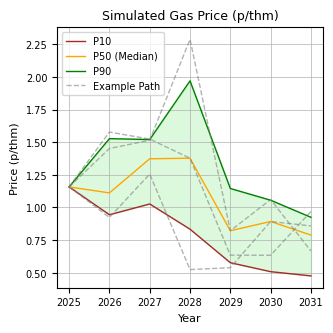

In [5]:
all_P_gas = np.array([path.state_variables["P_gas"] for path in fo_simulation.paths])

# Call the function
plot_state_variable_paths(
    years, 
    all_P_gas, 
    title="Simulated Gas Price (p/thm)", 
    ylabel="Price (p/thm)"
)


### Carbon

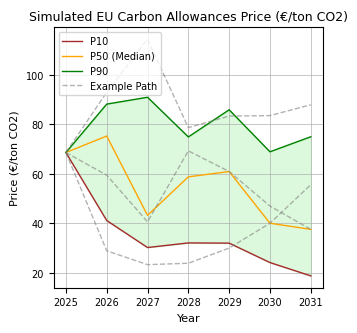

In [6]:
all_P_ets = np.array([path.state_variables["P_ets"] for path in fo_simulation.paths])

# Call the function
plot_state_variable_paths(
    years, 
    all_P_ets, 
    title="Simulated EU Carbon Allowances Price (€/ton CO2)", 
    ylabel="Price (€/ton CO2)"
)


## Base Case Results

In [7]:
ppa_price = 1450 # kr/MWh basert på utsira Nord "high"-case

In [8]:
npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs)
npv_fo = fo_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs)
print_currency_array("NPV WC", npv_wc)
print_currency_array("NPV FO", npv_fo)
print("NPV FO", f"{int(np.mean(npv_fo) / 1e6):,}".replace(",", " "))
print("NPV Net:", f"{int((np.mean(npv_wc) + np.mean(npv_fo)) / 1e6):,}".replace(",", " "))

NPV WC ['-10']
NPV FO ['1 045', '1 151', '1 079', '891', '1 018']
NPV FO 1 037
NPV Net: 1 026


### Wind Contractor Cash Flows

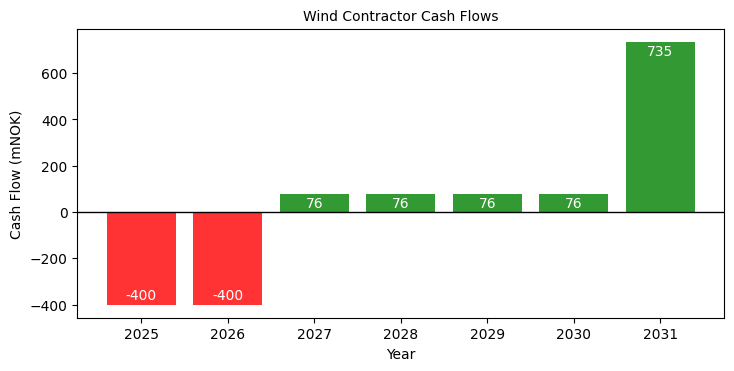

In [9]:
years = np.arange(2025, 2026+kwargs["LT_field"])
num_paths = W
cash_flows = wc_simulation.paths[0].cash_flows/1000000

# Call the function
plot_bar(
    years, 
    cash_flows, 
    title="Wind Contractor Cash Flows", 
    ylabel="Cash Flow (mNOK)"
)


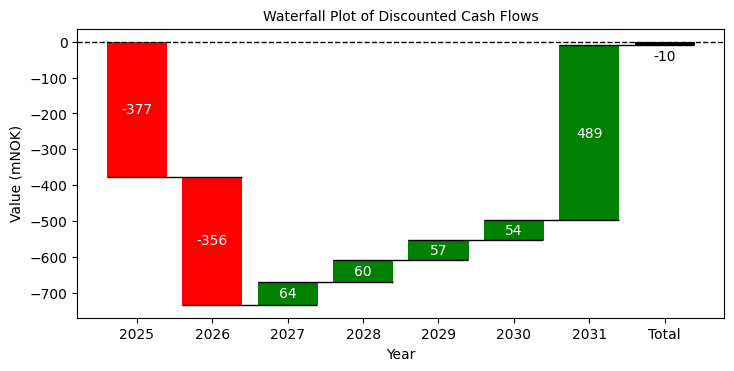

In [10]:
plot_waterfall(years, cash_flows, kwargs["r_WC"])

### Field Operator Cash Flows

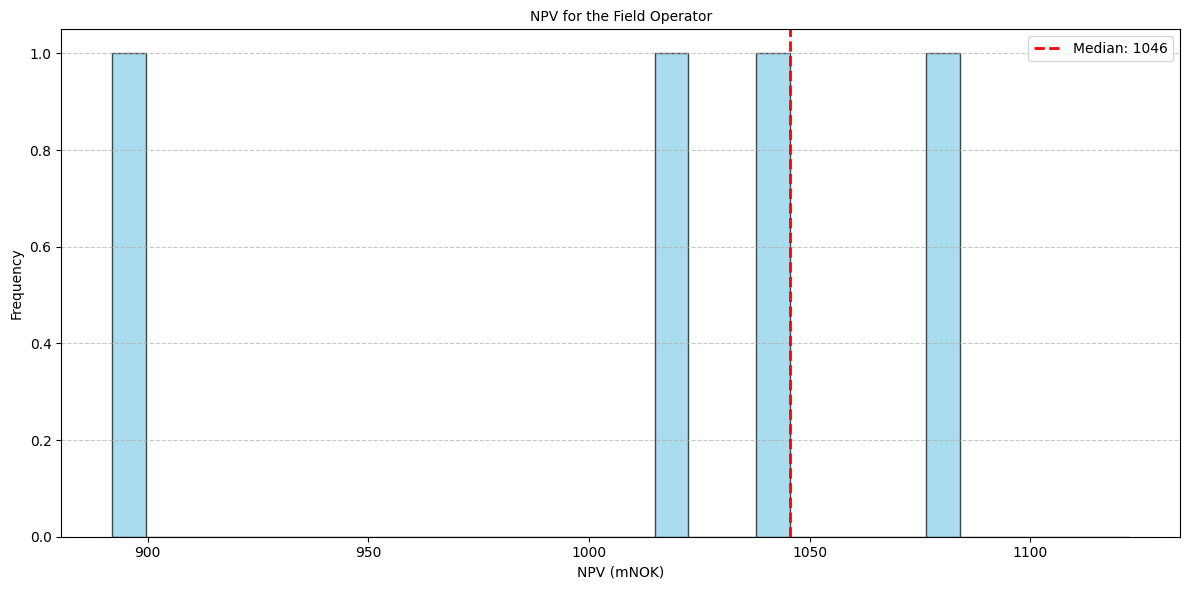

In [11]:
plot_histogram(np.array(npv_fo)/10**6, title="NPV for the Field Operator", xlabel="NPV (mNOK)")

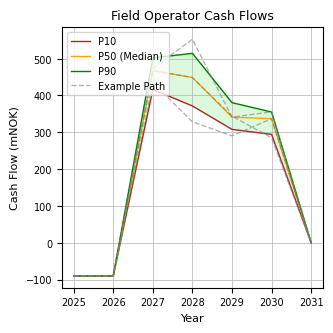

In [ ]:
state_variable_paths = np.array([path.cash_flows/1000000 for path in fo_simulation.paths])

# Call the function
plot_state_variable_paths(
    years, 
    state_variable_paths, 
    title="Field Operator Cash Flows", 
    ylabel="Cash Flow (mNOK)"
)


In [ ]:
ets_50 = np.percentile(all_P_ets, 50, axis=0) 
gas_50 = np.percentile(all_P_gas, 50, axis=0) 


class SpecialPathClass(MonteCarlo.Path):

    def __init__(self) -> None:
        super().__init__()

    def simulate_state_variables(self):
        P_ets_t = ets_50
        P_gas_t = gas_50

        return {"P_ets": P_ets_t, "P_gas": P_gas_t}

    def calculate_cash_flows(self,
        ppa_price,
        CAPEX_FO,
        r_FO,
        t_construction, LT_field,
        wind_annual_power_production,
        gas_CO2_emissions_factor, gas_NOx_emissions_factor,
        start_tax, end_tax, t_tax_ceiling, co2_tax_ceiling,
        NOx_support_rate, NOx_support_ceiling,
        gas_burned_without_owf,
        **kwargs
    ):

        # Capex
        self.CAPEX_FO_t = np.array(
            [-CAPEX_FO/t_construction for i in range(t_construction)] +
            [0 for i in range(LT_field - t_construction)] +
            [0]
        )

        # Carbon costs
        P_ets = self.state_variables["P_ets"] * 11.96 # converted to NOK / tCO2-eq
        self.co2_tax_rate = np.array(
            [start_tax + i * ((end_tax - start_tax)/t_tax_ceiling) for i in range(t_tax_ceiling)] +
            [(0 if P_ets[i] > co2_tax_ceiling else (co2_tax_ceiling - P_ets[i])*gas_CO2_emissions_factor) for i in range(t_tax_ceiling, LT_field + 1)]
        )

        self.avoided_co2_tax_t = np.concatenate((
            np.array([0 for i in range(t_construction)]), 
            ((self.co2_tax_rate)*gas_burned_without_owf)[t_construction:LT_field],
            np.array([0])
        ))

        self.avoided_co2_allowance_t = np.concatenate((
            np.array([0 for i in range(t_construction)]), 
            ((P_ets*gas_CO2_emissions_factor)*gas_burned_without_owf)[t_construction:LT_field],
            np.array([0])
        ))

        # Added gas sales
        P_gas_t = self.state_variables["P_gas"] * 5.360249 # converted to NOK / Sm^3 
        
        self.added_natural_gas_sales_t = np.concatenate((
            np.array([0 for i in range(t_construction)]), 
            (P_gas_t * gas_burned_without_owf)[t_construction:LT_field],
            np.array([0])
        ))
        
        # NOx fund
        self.government_funding_t = np.concatenate((
            np.array([0 for i in range(t_construction)]), 
            np.array([(
                (gas_NOx_emissions_factor*gas_burned_without_owf*NOx_support_rate) 
                if (gas_NOx_emissions_factor*gas_burned_without_owf*NOx_support_rate*i) < NOx_support_ceiling
                else (
                    NOx_support_ceiling - gas_NOx_emissions_factor*gas_burned_without_owf*NOx_support_rate*(i - 1)
                    if (gas_NOx_emissions_factor*gas_burned_without_owf*NOx_support_rate*(i - 1)) < NOx_support_ceiling
                    else 0
                )
            ) for i in range(LT_field - t_construction)]),
            np.array([0])
        ))

        # Electricity costs (payments to wind contractor)
        self.electricity_costs = - np.array(
            [0 for i in range(t_construction)] +
            [(-ppa_price * wind_annual_power_production) for i in range(LT_field - t_construction)] +
            [0]
        )

         
        self.cash_flows = (
            self.CAPEX_FO_t 
            + self.avoided_co2_tax_t + self.avoided_co2_allowance_t 
            + self.added_natural_gas_sales_t
            + self.government_funding_t
            + self.electricity_costs
        )

        return net_present_value(self.cash_flows, r_FO)

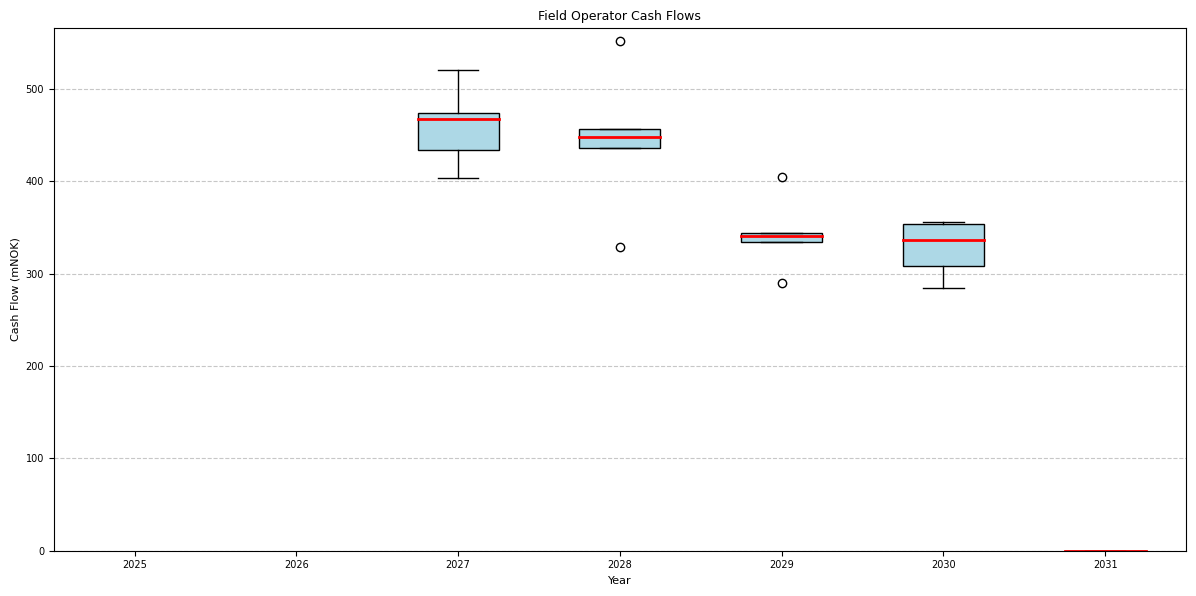

In [14]:
years = np.arange(2025, 2032)
num_paths = W
state_variable_paths = np.array([path.cash_flows/1000000 for path in fo_simulation.paths])

# Call the function
plot_state_variable_boxplots(
    years, 
    state_variable_paths, 
    title="Field Operator Cash Flows", 
    ylabel="Cash Flow (mNOK)"
)


# Sensitivity Analyses

## CAPEX

In [15]:
CAPEX_low = 000 * 10**6
CAPEX_high = 5000 * 10**6

### Wind Operator

In [16]:
def objective(CAPEX):
    kwargs_copy = kwargs.copy()
    kwargs_copy["CAPEX"] = CAPEX
    npv = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
    return npv

zero_level = brentq(objective, CAPEX_low, CAPEX_high)

ValueError: f(a) and f(b) must have different signs

In [ ]:
int(zero_level/1000000)

2320

### Net Project

In [ ]:
zero_levels = []

for path in fo_simulation.paths:
    def objective(CAPEX):
        kwargs_copy = kwargs.copy()
        kwargs_copy["CAPEX"] = CAPEX
        npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
        npv_fo = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy)
        return (npv_wc + npv_fo)

    zero_levels.append(brentq(objective, CAPEX_low, CAPEX_high)/1000000)

In [ ]:
np.quantile(zero_levels, 0.1)

2792.4600956428267

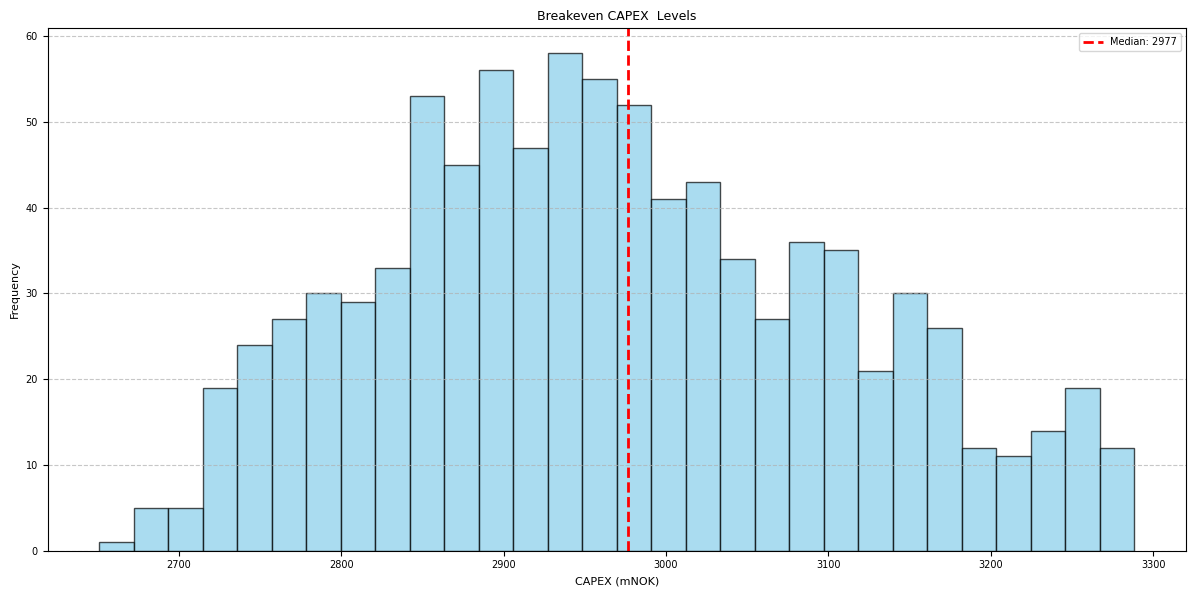

In [ ]:
plot_breakeven_histogram(
    zero_levels, 
    title="Breakeven CAPEX  Levels", 
    xlabel="CAPEX (mNOK)"
)

## PPA-price

In [ ]:
ppa_low = 0
ppa_high = 100000

### Wind Contractor

In [ ]:
CAPEX_line = [2000 * 10**6, 4000 * 10**6]
zero_level_line = []

In [ ]:
default_CAPEX = kwargs["CAPEX"]
for CAPEX in CAPEX_line:
    kwargs["CAPEX"] = CAPEX
    def objective(ppa_price):
        kwargs_copy = kwargs.copy()
        # kwargs_copy["CAPEX"] = CAPEX
        npv = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
        return npv

    zero_level_line.append(brentq(objective, ppa_low, ppa_high))

kwargs["CAPEX"] = default_CAPEX

In [ ]:
zero_level_line

[70.94239400666278, 8682.837186497756]

### Field Operator

In [ ]:
zero_levels = []

for path in fo_simulation.paths:
    def objective(ppa_price):
        kwargs_copy = kwargs.copy()
        # kwargs_copy["CAPEX"] = CAPEX
        npv = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy)
        return npv

    zero_levels.append(brentq(objective, ppa_low, ppa_high))

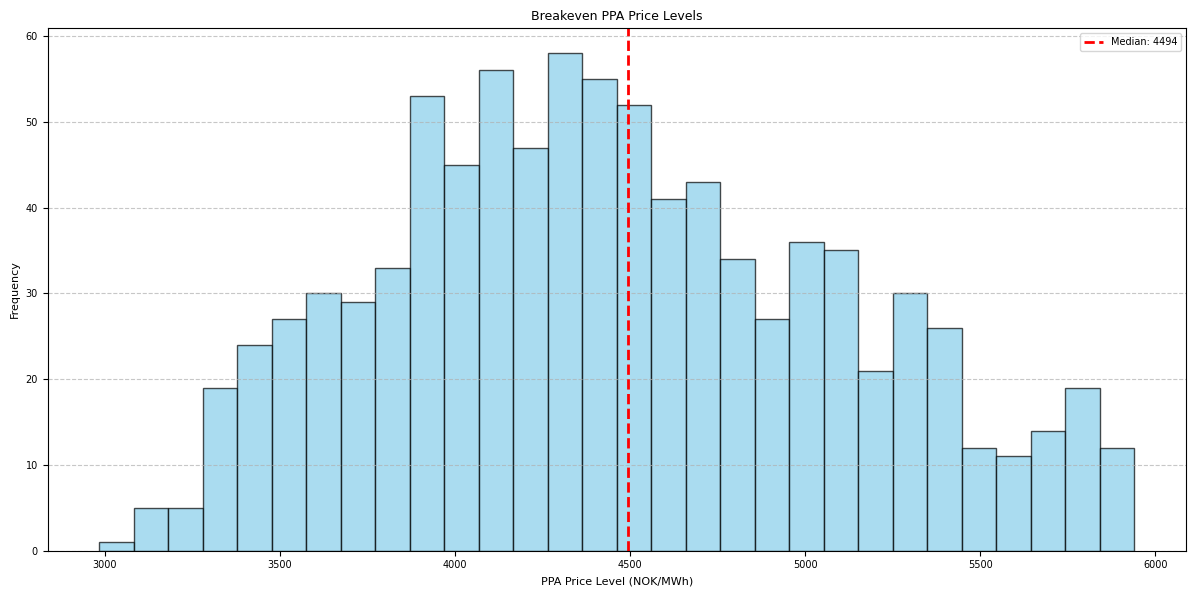

In [ ]:
plot_breakeven_histogram(
    zero_levels, 
    title="Breakeven PPA Price Levels", 
    xlabel="PPA Price Level (NOK/MWh)"
)

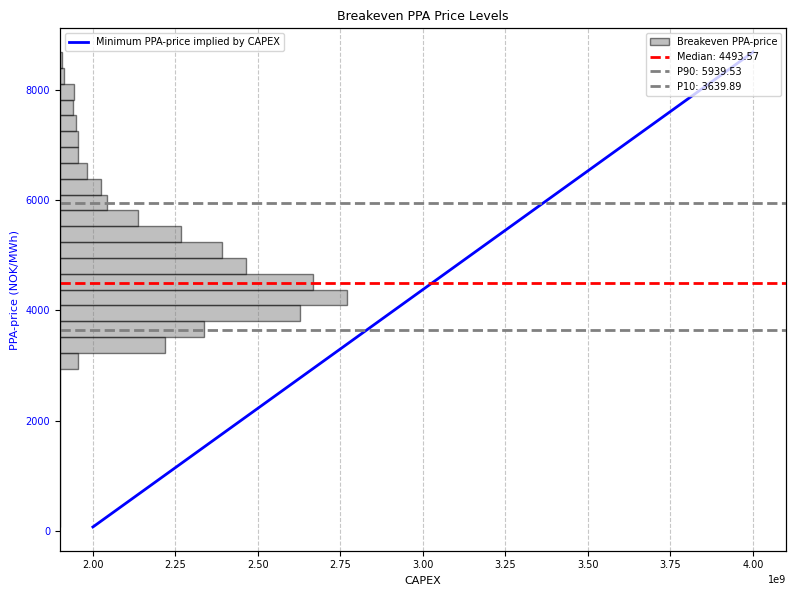

In [ ]:
plot_histogram_with_line(
    CAPEX_line, zero_level_line, zero_levels,
    line_label="Minimum PPA-price implied by CAPEX", histogram_label="Breakeven PPA-price",
    x_label_line="CAPEX", y_label_line="PPA-price (NOK/MWh)",
    title="Breakeven PPA Price Levels"
    )

## Resale Value

In [ ]:
wind_residual_value_low = -10000 * 10**6
wind_residual_value_high = 10000 * 10**6

### Wind Operator

In [ ]:
objective(0)

1138631447.885313

In [ ]:
def objective(wind_residual_value):
    kwargs_copy = kwargs.copy()
    kwargs_copy["wind_residual_value"] = wind_residual_value
    npv = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
    return npv

zero_level = brentq(objective, wind_residual_value_low, wind_residual_value_high)

In [ ]:
int(zero_level/1000000)

-176

### Net Project

In [ ]:
zero_levels = []

for path in fo_simulation.paths:
    def objective(wind_residual_value):
        kwargs_copy2 = kwargs.copy()
        kwargs_copy2["wind_residual_value"] = wind_residual_value
        npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy2)[0]
        npv_fo = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy2)
        return (npv_wc + npv_fo)

    zero_levels.append(brentq(objective, wind_residual_value_low, wind_residual_value_high)/1000000)

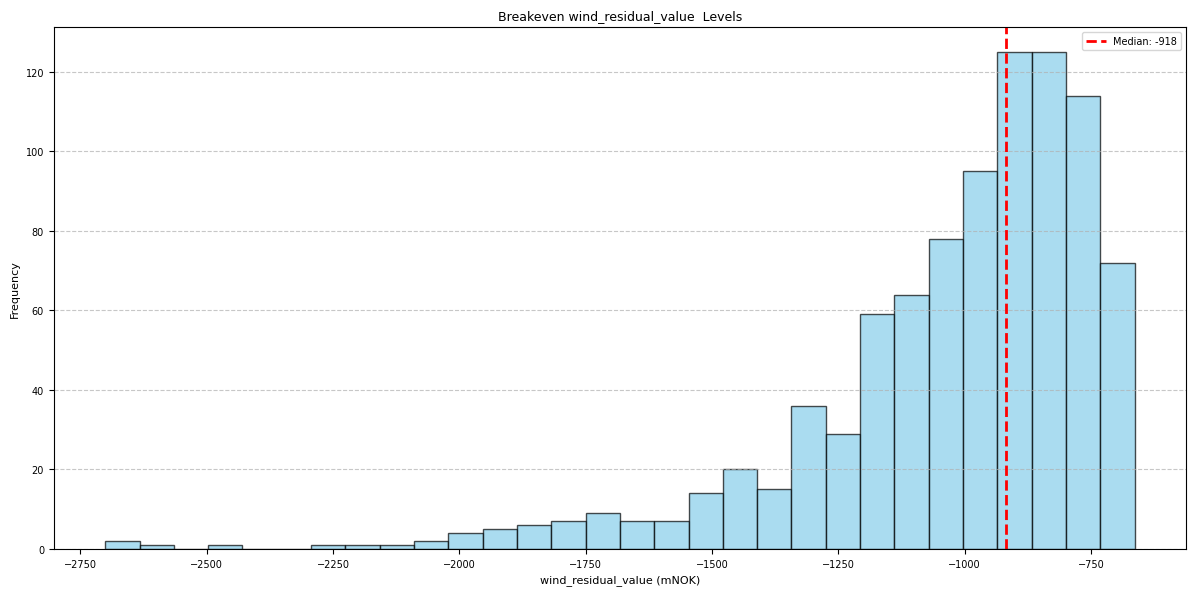

In [ ]:
plot_breakeven_histogram(
    zero_levels, 
    title="Breakeven wind_residual_value  Levels", 
    xlabel="wind_residual_value (mNOK)"
)

### CAPEX vs Residual Value

In [ ]:
resid_levels_50 = []
resid_levels_90 = []
capex_levels = np.arange(2000, 4001, 2000) * 10 ** 6
for CAPEX in capex_levels:
    kwargs_copy = kwargs.copy()
    kwargs_copy["CAPEX"] = CAPEX

    zero_levels = []

    for path in fo_simulation.paths:
        def objective(wind_residual_value):
            kwargs_copy2 = kwargs_copy.copy()
            kwargs_copy2["wind_residual_value"] = wind_residual_value
            npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy2)[0]
            npv_fo = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy2)
            return (npv_wc + npv_fo)

        zero_levels.append(brentq(objective, wind_residual_value_low, wind_residual_value_high)/1000000)
    
    resid_levels_50.append(np.median(zero_levels))
    resid_levels_90.append(np.quantile(zero_levels, 0.9))

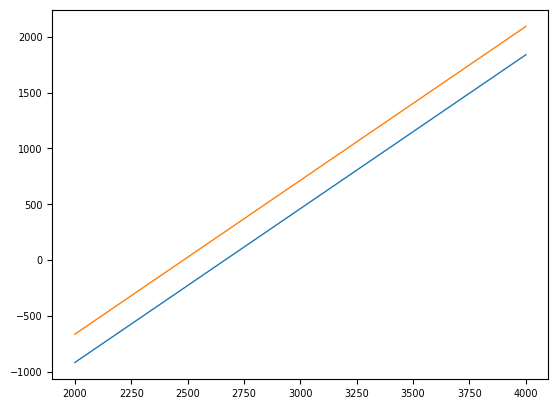

In [ ]:
plt.plot(capex_levels/(10**6), resid_levels_50)
plt.plot(capex_levels/(10**6), resid_levels_90)

### Plan further
 - 

***
***
# Junkyard
***


### Net Project

In [ ]:
zero_levels = []

num_npv_negative = 0

for path in fo_simulation.paths:
    def objective(ppa_price):
        kwargs_copy = kwargs.copy()
        npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
        npv_fo = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy)
        print(npv_wc, npv_fo, npv_wc + npv_fo)
        return (npv_wc - npv_fo)
    
    zero_levels.append(brentq(objective, ppa_low, ppa_high))
    # except ValueError:
    #     num_npv_negative += 1
    #     continue


-16009157.581164658 917523999.0822761 901514841.5011115
22550409420.936367 -20034575223.54747 2515834197.388897
468072126.3093592 468072126.3093591 936144252.6187183
468072126.30935884 468072126.3093594 936144252.6187181
-16009157.581164658 1023869004.8269771 1007859847.2458124
22550409420.936367 -19928230217.802765 2622179203.133602
523217063.10007197 523217063.1000719 1046434126.2001438
523217063.1000714 523217063.1000725 1046434126.2001438
-16009157.581164658 951207459.0215548 935198301.4403901
22550409420.936367 -20000891763.60819 2549517657.3281784
485538600.2282492 485538600.2282492 971077200.4564984
-16009157.581164658 763176822.4106419 747167664.8294773
22550409420.936367 -20188922400.2191 2361487020.717266
388035783.82407653 388035783.8240765 776071567.6481531
388035783.82407606 388035783.8240769 776071567.648153
-16009157.581164658 890722371.9520608 874713214.3708961
22550409420.936367 -20061376850.67768 2489032570.258686
454174209.5841291 454174209.5841288 908348419.168258
4

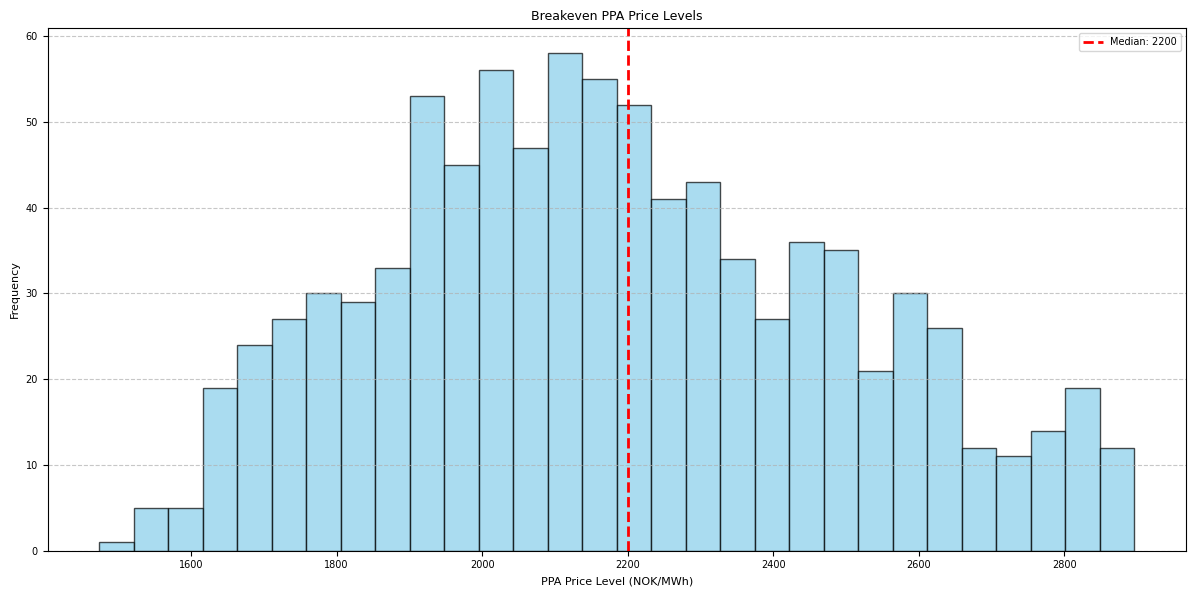

In [ ]:
plot_breakeven_histogram(
    zero_levels, 
    title="Breakeven PPA Price Levels", 
    xlabel="PPA Price Level (NOK/MWh)"
)